# dev adaptive time stepping - letting tetrahedral elements learn their own step size

In [17]:
%matplotlib inline
from lib.my_initialization import *
from lib.controller.one_step_forward_euler import *
from lib.controller.simple_explicit_time_adaptation import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# initialize

In [38]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .0#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0001#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.0001#0.001#1e-10; 
btol_v = 0.0001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_100.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Synchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [39]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

# #let's try 100 bins
# learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
#         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
#         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
#         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
#         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
#         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
#         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
#         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
#         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
#         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
#         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
#         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
#         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
#         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
#         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
#         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
#         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
#         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
#         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
#         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
#         0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [3.05175781e-09 6.10351563e-09 1.22070313e-08 2.44140625e-08
 4.88281250e-08 9.76562500e-08 1.95312500e-07 3.90625000e-07
 7.81250000e-07 1.56250000e-06 3.12500000e-06 6.25000000e-06
 1.25000000e-05 2.50000000e-05 5.00000000e-05 1.00000000e-04
 2.00000000e-04 4.00000000e-04 8.00000000e-04 1.60000000e-03
 3.20000000e-03 6.40000000e-03 1.28000000e-02 2.56000000e-02
 5.12000000e-02 1.02400000e-01 2.04800000e-01 4.09600000e-01
 8.19200000e-01 1.63840000e+00]


### deprecated

In [2]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_100.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))
tauK = element_array_time
tau = node_array_time

#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = 0.#1.#1.;

#define adaptive time stepping absolute tolerances
atol_x = 0.001#1e-7; 
atol_v = 0.001#1e-7; 
btol_x = 1e-10; btol_v = 1e-10; 
learning_rate = np.log(2)
lasso_fraction = 0.5

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

N_elements = elements.shape[0]
N_vertices = vertices.shape[0]

#initialize stepsizes of simulation
stepsize_init = 0.001#0.0001 
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
v_scale = -1.
velocities[:,0] = v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']
learning_bins are [0.00017678 0.00035355 0.00070711 0.00141421 0.00282843 0.00565685]


# (deprecated) define some functions

In [3]:
# def _compute_next_time(K, t, stepsize):
# 	'''compute next time for element's evaluation'''
# 	return t + stepsize

# def compute_one_step_map_forward_euler(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat):
# 	Na = 4 # number of tetrahedral nodes, which is 4
# 	# t, K_index, vertices, velocities, Ka, tau, tauK, elements, element_array_inverse_equilibrium_position, zero_mat, node_array_mass):
# 	Delta_x = np.multiply (K_velocities[a] , (t - K_tau[a]))
# 	for a in range(Na):
# 		K_vertices[a] = K_vertices[a] + Delta_x[a]
# 	#update node times
# 	for a in range(Na):
# 		K_tau[a] = t
# 	#compute the nodal forces for each tetrahedral node
# 	f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
# 	#TODO(later): include any other forces, such as nodal forces, pressure forces, etc.
# 	#net nodal forces
# 	force = f
# 	Delta_v = np.multiply ( (t - tau_of_K) / K_masses , force )
# 	#update node velocities 
# 	for a in range(Na):
# 		K_velocities[a] = K_velocities[a] + Delta_v[a]
# 	#TODO(later): if node is not a boundary node, set velocity to zero
# 	return Delta_x, Delta_v

### outline
- TODO: update node positions to the half time (t_lesser-tau[a] from the original time
- TODO: compute one

In [4]:
# one_step_forward_euler_simplified = get_one_step_forward_euler_simplified(mu,lam)
# K_vertices, K_velocities = one_step_forward_euler_simplified(t, K_vertices, K_velocities, 
# 	K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)
# #TODO(later): if node is a boundary node, set velocity to zero
# #update element's time
# tauK[K_index] = t
# #compute next time for element's evaluation
# tKnext = t + stepsize #_compute_next_time(K, t, stepsize)


# compute_one_step_map_forward_euler(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)

# compute_one_step_map_forward_euler(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Ds, Bm, K_W, zero_mat)

# initialize one simple element 
(for development purposes)

In [5]:
X = np.array([[0, 0, 1], [0, 1, 0],
                  [-1, 0, 0], [+1, 0, 0]], dtype=float)
x = X.copy()
x[:,0] *= 2
elements = np.array([[0,1,2,3]])
K_index = 0
K_W = compute_element_volume(node_array_position=x, element_array_index=elements, K_index=K_index)
Ka = elements[K_index]

Bm = compute_inverse_position(node_array_position=X, element_array_index=elements, K_index=K_index)
# Bm  = element_array_inverse_equilibrium_position[K_index]
K_vertices = x[Ka]
K_velocities = velocities[Ka]

# print( (K_vertices, K_W, Bm, zero_mat.copy()) ) 

In [6]:
#given initialization as in explicit.py
#simplified elemental time update
tau = np.array([0.,0.,0.,0.,])
tauK= np.array([0.])

# Bm  = element_array_inverse_equilibrium_position[K_index]
# Ka  = elements[K_index]
# K_vertices   = vertices[Ka]
# K_velocities = velocities[Ka]
K_masses     = node_array_mass[Ka]
K_tau        = tau[Ka]
tau_of_K     = tauK[K_index]
# Ds  = get_D_mat(K_vertices)
# Bm  = element_array_inverse_equilibrium_position[K_index]
# K_W = get_element_volume(Ds)

In [7]:
f   = compute_nodal_elastic_forces(K_vertices, K_W, Bm, f = zero_mat.copy())
f

array([[ 0.        ,  0.        , -0.46209812],
       [ 0.        , -0.46209812,  0.        ],
       [ 0.61552453,  0.23104906,  0.23104906],
       [-0.61552453,  0.23104906,  0.23104906]])

# draft outline of simplest method of explicit time adaptation

In [8]:
#let the pop have the form
t_given, K_index = 0.1, 0
tau_of_K   = tauK[K_index]
DT_given   = t_given - tau_of_K
DT_lesser  = DT_given/2
DT_greater = DT_given*2
t_lesser   = DT_lesser  + tau_of_K
t_greater  = DT_greater + tau_of_K

#split the elemental configuration into three possibiities
x_A = K_vertices.copy()
x_B = x_A.copy()
x_C = x_B.copy()
v_A = K_velocities.copy()
v_B = v_A.copy()
v_C = v_B.copy()
tau_of_K_A = tau_of_K.copy()
tau_of_K_B = tau_of_K_A.copy()
tau_of_K_C = tau_of_K_B.copy()
K_tau_A = K_tau.copy()
# K_tau_A[0] += 0.01
K_tau_B = K_tau_A.copy()
K_tau_C = K_tau_B.copy()

# #update node positions
# Delta_x = 0.*x_A
# for a in range(Na):
#     Delta_x[a] =  v_A[a] * (t_lesser - K_tau_A[a])
# x_A += Delta_x

#The following does the same thing as the above.  The first one (above) will probably njit more eaisily...
# Dtau = (t_lesser - K_tau_A)
# Delta_x = np.multiply ( np.vstack([Dtau,Dtau,Dtau]).T, v_A )
# Delta_x

#The old method :
# for a in range(Na):
#     x_A[a] = x_A[a] + v_A[a] * (t_lesser - K_tau_A[a])

comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu,lam)

#def  t, K_index, vertices, velocities, Ka, tau, tauK, elements, element_array_inverse_equilibrium_position, zero_mat, node_array_mass):
Na = 4 # number of tetrahedral nodes, which is 4
Delta_x = 0.*x_A
Delta_v = 0.*v_A

#compute the first of two half-stepped elemental configurations

#update node positions
for a in range(Na):
    Delta_x[a] =  v_A[a] * (t_lesser - K_tau_A[a])
    #update node times
    K_tau_A[a] = t_lesser
x_A += Delta_x
#compute the nodal forces for each tetrahedral node
Ds  = get_D_mat(x_A)
K_W = get_element_volume(Ds)
f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
#net nodal forces
force   = f
#update node velocities 
for a in range(Na):
    Delta_v[a] =  (t_lesser - tau_of_K_A) * force[a] / K_masses[a]
v_A += Delta_v
#update element time
tau_of_K_A = t_lesser
# #TODO(later): if node is a boundary node, set velocity to zero

print ( Delta_x )
print ( Delta_v ) 


#compute the second half-stepped elemental configurations
#update node positions
for a in range(Na):
    Delta_x[a] =  v_A[a] * (t_given - K_tau_A[a])
    #update node times
    K_tau_A[a] = t_given
x_A += Delta_x
#compute the nodal forces for each tetrahedral node
Ds  = get_D_mat(x_A)
K_W = get_element_volume(Ds)
f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
#net nodal forces
force   = f
#update node velocities 
for a in range(Na):
    Delta_v[a] =  (t_given - tau_of_K_A) * force[a] / K_masses[a]
v_A += Delta_v
#update element time
tau_of_K_A = t_given
# #TODO(later): if node is a boundary node, set velocity to zero

print ( Delta_x )
print ( Delta_v ) 


#compute the one-stepped elemental configurations
#update node positions
for a in range(Na):
    Delta_x[a] =  v_B[a] * (t_given - K_tau_B[a])
    #update node times
    K_tau_B[a] = t_given
x_B += Delta_x
#compute the nodal forces for each tetrahedral node
Ds  = get_D_mat(x_B)
K_W = get_element_volume(Ds)
f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
#net nodal forces
force   = f
#update node velocities 
for a in range(Na):
    Delta_v[a] =  (t_given - tau_of_K_B) * force[a] / K_masses[a]
v_B += Delta_v
#update element time
tau_of_K_B = t_given
# #TODO(later): if node is a boundary node, set velocity to zero

print ( Delta_x )
print ( Delta_v ) 


# compute the max absolute difference (mad) in position and velocity between the two step sizes
mad_xBA = np.max(np.abs(x_B-x_A))
mad_vBA = np.max(np.abs(v_B-v_A))
print ( (mad_xBA, mad_vBA) )
print('''NOTE: if either of ^these values are above some threshold, 
      then decrease the stepsize and restart the onestep method to be safe.''')
if (mad_xBA > atol_x) | (mad_vBA > atol_v):
    #TODO: restart the algorithm with half the stepsize and return the result 
    retval = (x_A.copy(), v_A.copy(), K_tau_A.copy(), tau_of_K_A)
    next_stepsize = DT_lesser
else:
    #store the given step for potential later use
    retval = (x_B.copy(), v_B.copy(), K_tau_B.copy(), tau_of_K_B)
    next_stepsize = DT_given

#compute the one-stepped elemental configurations
#update node positions
for a in range(Na):
    Delta_x[a] =  v_B[a] * (t_greater - K_tau_B[a])
    #update node times
    K_tau_B[a] = t_greater
x_B += Delta_x
#compute the nodal forces for each tetrahedral node
Ds  = get_D_mat(x_B)
K_W = get_element_volume(Ds)
f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
#net nodal forces
force   = f
#update node velocities 
for a in range(Na):
    Delta_v[a] =  (t_greater - tau_of_K_B) * force[a] / K_masses[a]
v_B += Delta_v
#update element time
tau_of_K_B = t_greater
# #TODO(later): if node is a boundary node, set velocity to zero

print ( Delta_x )
print ( Delta_v ) 


#compute the two double-stepped elemental configurations
#update node positions
for a in range(Na):
    Delta_x[a] =  v_C[a] * (t_greater - K_tau_C[a])
    #update node times
    K_tau_C[a] = t_greater
x_C += Delta_x
#compute the nodal forces for each tetrahedral node
Ds  = get_D_mat(x_C)
K_W = get_element_volume(Ds)
f   = comp_nodal_elastic_forces(K_W, Bm, Ds, zero_mat.copy())
#net nodal forces
force   = f
#update node velocities 
for a in range(Na):
    Delta_v[a] =  (t_greater - tau_of_K_C) * force[a] / K_masses[a]
v_B += Delta_v
#update element time
tau_of_K_C = t_greater
# #TODO(later): if node is a boundary node, set velocity to zero

print ( Delta_x )
print ( Delta_v ) 


# compute the max absolute difference (mad) in position and velocity between the two step sizes
mad_xCB = np.max(np.abs(x_C-x_B))
mad_vCB = np.max(np.abs(v_C-v_B))
print ( (mad_xCB, mad_vCB) )
print('''NOTE: if either of ^these values are below some threshold, 
      then you may consider increasing the stepsize and using this result.  
      Don`t bother restarting the one step method.''')
if (mad_xCB < btol_x) | (mad_vCB < btol_v):
    #restart the algorithm with double the stepsize and return the result 
    #OR simply return the result for case C
    retval = (x_C.copy(), v_C.copy(), K_tau_C.copy(), tau_of_K_C, )
    next_stepsize = DT_greater

# TODO: make sure everything's updated correctly 
#TODO: decide which of ^these to keep 
# and which stepsize to use for the next time
#TODO: put ^this all in a nice function that returns something I can push to the p.queue.
# if (mad_xBA > atol_x) | (mad_vBA > atol_v):
#     TODO: restart the algorithm with half the stepsize and return the result 

# #compute next time for element's evaluation
# tKnext = t + stepsize #_compute_next_time(K, t, stepsize)
# for a in range(Na):
#     K_velocities[a] = K_velocities[a] + Delta_v[a]
#TODO(later): if node is not a boundary node, set velocity to zero
# return Delta_x, Delta_v

# make measures of stepsize distribution

In [8]:
os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
tme = 0.
mass_density=1.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
print(list(dict_values_system.keys()))

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [9]:
#define Lamé parameters
mu = 1.; lam = 1.; 
#define coefficient for Rayleigh damping
gamma = 1.;

#define adaptive time stepping absolute tolerances
atol_x = 1e-4; atol_v = 1e-4; 
btol_x = 1e-12; btol_v = 1e-12; 


In [7]:
element_array_count_one_steps = np.zeros_like(element_array_mass)

## naive courant limit

In [25]:
#speed of volumetric wave propagation in the undeformed material
c = np.sqrt((lam + 2 * mu) / mass_density)

_From Adrian's Thesis_<br>
The Courant condition, which provides an estimate of the stability limit for explicit integration (cf, e.g., Hughes [1987]). Specifically, the value of the time step for each element is set to a fraction of the Courant limit and is computed as
$
\Delta t = \frac{h}{10c}
$
where h is the radius of the largest sphere that can fit inside of a tetrahedron.

For a regular tetrahedron, this value is $h = 6y\sqrt(12)$, where y is the side length.  I could approximate this value with the minimum side length (complicated to implement) or $1/4$ of the mean side length (simple to implement).

In [26]:
#an example volume
K_index = 57
Ka = element_array_index[K_index]
K_vertices = node_array_position[Ka]
D = get_D_mat(K_vertices)
vol = np.abs(np.linalg.det(D)/6)
print(vol)

0.00021099074831963375


In [27]:
#naive approximation is that everything is a sphere
h_naive = np.cbrt(vol)/(3/4/np.pi)
courant_limit_naive = h_naive/(10*c)
print ( courant_limit_naive )

0.014397346362187488


^this max time step is consistent with what I observe from guess-and-checking the actual simulation.

# make a (njit'd)  "button" for the implicit midpoint rule
- a second order accurate method will work much better than a first order method for the sakes of letting elements learn their own timestep
<!-- -  TODO:
- (and then) TODO: play with ^that for an iterative soln for an implicit method (BEI or IMR) -->

In [8]:
tauK = element_array_time
tau = node_array_time
# one_step_forward_euler_method = get_one_step_forward_euler_method(mu,lam,gamma)
compute_one_step_forward_euler_method=get_compute_one_step_forward_euler_method(mu,lam,gamma)

In [9]:
t = 0.001
h = 0.001
K_index = 7

In [18]:
#actionables per function call are as follow:
t_previous = tauK[K_index]
x_current, v_current = vertices[element_array_index[K_index]], velocities[element_array_index[K_index]]
#compute the namespace of the force computation of the elemental configuration
Ka = element_array_index[K_index]
tau_of_K = tauK[K_index]
K_tau = tau[Ka]
K_vertices = vertices[Ka].copy()
K_velocities = velocities[Ka].copy()
K_masses = node_array_mass[Ka]
Bm  = element_array_inverse_equilibrium_position[K_index]
#initialize the first iterate of the soln to the implicit midpoint rule
K_vertices, K_velocities = compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Bm, zero_mat)

iter_count =0
x_next, v_next = K_vertices.copy(), K_velocities.copy()
x_avg = x_current/2. + x_next/2.
v_avg = v_current/2. + v_next/2.

num_iter = 30
madx_lst = []
madv_lst = []
k_lst = []
for k in range(num_iter):
    #compute the next iterate of the soln to the implicit midpoint rule num_iter times
    K_vertices, K_velocities = compute_one_step_forward_euler_method(t, x_avg, v_avg, K_masses, K_tau, tau_of_K, Bm, zero_mat)
    iter_count +=1
    delta_x = K_vertices - x_next
    delta_v = K_velocities - v_next
    x_next, v_next = K_vertices.copy(), K_velocities.copy()
    x_avg = x_current/2. + x_next/2.
    v_avg = v_current/2. + v_next/2.
    madx = np.max(np.abs(delta_x))
    madv = np.max(np.abs(delta_v))
    madx_lst.append(madx)
    madv_lst.append(madv)
    k_lst.append(k)

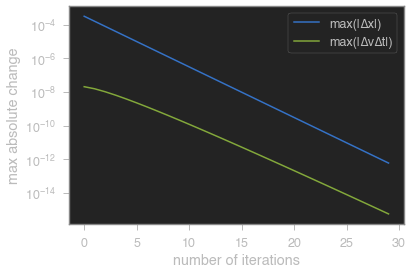

In [19]:
plt.plot(k_lst, madx_lst, label='max(|∆x|)')
plt.plot(k_lst, np.array(madv_lst)*h, label='max(|∆v∆t|)')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('max absolute change')
plt.yscale('log')
plt.show()

In [14]:
def get_one_step_implicit_midpoint_rule(mu,lam,gamma,num_iter = 30):
    zero_mat = np.zeros((4,3))
    compute_one_step_forward_euler_method=get_compute_one_step_forward_euler_method(mu,lam,gamma)
    @njit
    def one_step_implicit_midpoint_rule(K_index, tauK, tau, vertices, velocities, 
                                        node_array_mass, element_array_inverse_equilibrium_position):
        #actionables per function call are as follow:
        t_previous = tauK[K_index]
        Ka = element_array_index[K_index]
        x_current, v_current = vertices[Ka], velocities[Ka]
        #compute the namespace of the force computation of the elemental configuration
        tau_of_K = tauK[K_index]
        K_tau = tau[Ka]
        K_vertices = vertices[Ka].copy()
        K_velocities = velocities[Ka].copy()
        K_masses = node_array_mass[Ka]
        Bm  = element_array_inverse_equilibrium_position[K_index]
        #initialize the first iterate of the soln to the implicit midpoint rule
        K_vertices, K_velocities = compute_one_step_forward_euler_method(t, K_vertices, K_velocities, K_masses, K_tau, tau_of_K, Bm, zero_mat)
        x_next, v_next = K_vertices.copy(), K_velocities.copy()
        x_avg = x_current/2. + x_next/2.
        v_avg = v_current/2. + v_next/2.
        # madx_lst = []
        # madv_lst = []
        # k_lst = []
        # iter_count =0
        for k in range(num_iter):
            #compute the next iterate of the soln to the implicit midpoint rule num_iter times
            K_vertices, K_velocities = compute_one_step_forward_euler_method(t, x_avg, v_avg, K_masses, K_tau, tau_of_K, Bm, zero_mat)
            #     iter_count +=1
            #     delta_x = K_vertices - x_next
            #     delta_v = K_velocities - v_next
            x_next, v_next = K_vertices.copy(), K_velocities.copy()
            x_avg = x_current/2. + x_next/2.
            v_avg = v_current/2. + v_next/2.
            #     madx = np.max(np.abs(delta_x))
            #     madv = np.max(np.abs(delta_v))
            #     madx_lst.append(madx)
            #     madv_lst.append(madv)
            #     k_lst.append(k)
        return x_next, v_next
    return one_step_implicit_midpoint_rule

In [15]:
compute_one_step_implicit_midpoint_rule = get_one_step_implicit_midpoint_rule(mu,lam,gamma,num_iter = 30)

In [19]:
K_vertices, K_velocities = compute_one_step_implicit_midpoint_rule(K_index, tauK, tau, vertices, velocities, 
                                        node_array_mass, element_array_inverse_equilibrium_position)

In [20]:
K_vertices, K_velocities = compute_one_step_implicit_midpoint_rule(K_index, tauK, tau, vertices, velocities, 
                                        node_array_mass, element_array_inverse_equilibrium_position)

In [21]:
t

0.001

# dev letting tetrahedral elements learn their own step size
- DONE: implement adaptive time stepping (used the outline earlier in this *.ipynb

## work through one iterate

__sanity check__ I verified other args aren't updated by step_to_time.

In [3]:
local_one_step_implicit_midpoint_rule = get_local_one_step_implicit_midpoint_rule(mu,lam,gamma,num_iter = 30)
step_to_time = local_one_step_implicit_midpoint_rule


In [4]:
#let the pop have the form
t_given, K_index = 0.001, 7 #t_given is the time given to step to

In [5]:
Ka = element_array_index[K_index]
K_tau = node_array_time[Ka]
tau_of_K = element_array_time[K_index]
Bm  = element_array_inverse_equilibrium_position[K_index]
K_masses = node_array_mass[Ka]
x_current = vertices[Ka]
v_current = velocities[Ka]

#split the elemental configuration into three possibiities
x_A = x_current.copy()
x_B = x_current.copy()
x_C = x_current.copy()
v_A = v_current.copy()
v_B = v_current.copy()
v_C = v_current.copy()
tau_of_K_A = tau_of_K.copy()
tau_of_K_B = tau_of_K.copy()
tau_of_K_C = tau_of_K.copy()
K_tau_A = K_tau.copy()# K_tau_A[0] += 0.01
K_tau_B = K_tau.copy()
K_tau_C = K_tau.copy()

In [6]:
#define time steps options
DT_given   = t_given - tau_of_K
DT_lesser  = DT_given/2
DT_greater = DT_given*2
t_lesser   = DT_lesser  + tau_of_K
t_greater  = DT_greater + tau_of_K

In [7]:
#update config A to time t_lesser
x_A, v_A = step_to_time(t_lesser,
        x_A,
        v_A,K_masses,
        K_tau_A,
        tau_of_K_A,Bm,zero_mat)
#update times
K_tau_A    = t_lesser + 0.*K_tau_A
tau_of_K_A = t_lesser
#updateteims
#update config A to time t_given
x_A, v_A = step_to_time(t_given,
        x_A,
        v_A,K_masses,
        K_tau_A,
        tau_of_K_A,Bm,zero_mat)
#update times
K_tau_A    = t_given + 0.*K_tau_A
tau_of_K_A = t_given

In [8]:
#update config B to time t_given
x_B, v_B = step_to_time(t_given,
        x_B,
        v_B,K_masses,
        K_tau_B,
        tau_of_K_B,Bm,zero_mat)
#update times
K_tau_B    = t_given + 0.*K_tau_B
tau_of_K_B = t_given

In [9]:
# compute the max absolute difference (mad) in position and velocity between the two step sizes
mad_xBA = np.max(np.abs(x_B-x_A))
mad_vBA = np.max(np.abs(v_B-v_A))
print ( (mad_xBA, mad_vBA) )
print ( (atol_x, atol_v) )
# NOTE: if either of ^these values are above some threshold, 
# then decrease the stepsize and restart the onestep method to be safe.
if (mad_xBA > atol_x) | (mad_vBA > atol_v):
    #TODO: restart the algorithm with half the stepsize and return the result 
    print('TODO: restart the algorithm with half the stepsize and return the result')
    retval = (x_A.copy(), v_A.copy(), K_tau_A.copy(), tau_of_K_A)
    next_stepsize = DT_lesser
else:
    #store the given step for potential later use
    retval = (x_B.copy(), v_B.copy(), K_tau_B.copy(), tau_of_K_B)
    next_stepsize = DT_given

(3.918814572845264e-08, 2.6117379318121788e-05)
(0.0001, 0.0001)


In [10]:
#update config B to time t_greater
x_B, v_B = step_to_time(t_greater,
        x_B,
        v_B,K_masses,
        K_tau_B,
        tau_of_K_B,Bm,zero_mat)
#update times
K_tau_B    = t_greater + 0.*K_tau_B
tau_of_K_B = t_greater

In [11]:
#update config C to time t_greater
x_C, v_C = step_to_time(t_greater,
        x_C,
        v_C,K_masses,
        K_tau_C,
        tau_of_K_C,Bm,zero_mat)
#update times
K_tau_C    = t_greater + 0.*K_tau_C
tau_of_K_C = t_greater

In [17]:
# compute the max absolute difference (mad) in position and velocity between the two step sizes
mad_xCB = np.max(np.abs(x_C-x_B))
mad_vCB = np.max(np.abs(v_C-v_B))
print ( (mad_xCB, mad_vCB) )
print ( (atol_x, atol_v) )
# print ( (btol_x, btol_v) )
# NOTE: if either of ^these values are below some threshold, 
#     then you may consider increasing the stepsize and using this result.  
#     Don`t bother restarting the one step method.
# if (mad_xBA > atol_x) | (mad_vBA > atol_v):
# if (mad_xCB < btol_x) | (mad_vCB < btol_v):
if (mad_xCB < atol_x) & (mad_vCB < atol_v):
    #restart the algorithm with double the stepsize and return the result 
    #OR simply return the result for case C
    retval = (x_C.copy(), v_C.copy(), K_tau_C.copy(), tau_of_K_C, )
    next_stepsize = DT_greater

(3.109347037622001e-07, 0.00010350332277492665)
(0.0001, 0.0001)


WHich case won? Case B won, but ony barely over case C.  atol = 0.0001 and madv_CB = 0.00010350332277492665

## DONE: put ^this all in a nice function that returns something I can push to the p.queue.


In [3]:
local_one_step_implicit_midpoint_rule = get_local_one_step_implicit_midpoint_rule(mu,lam,gamma,num_iter = 30)
step_to_time = local_one_step_implicit_midpoint_rule


In [4]:
#let the pop have the form
t_given, K_index = 0.001, 7 #t_given is the time given to step to

In [18]:
step_forward_and_learn(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v)

NameError: name 'step_to_time' is not defined

In [6]:
# def step_forward_and_learn(K_index, node_array_time, element_array_time, vertices, velocities, element_array_index, 
#                            element_array_inverse_equilibrium_position, node_array_mass, atol
#                           ):
#     Ka = element_array_index[K_index]
#     K_tau = node_array_time[Ka]
#     tau_of_K = element_array_time[K_index]
#     Bm  = element_array_inverse_equilibrium_position[K_index]
#     K_masses = node_array_mass[Ka]
#     x_current = vertices[Ka]
#     v_current = velocities[Ka]
#     #split the elemental configuration into three possibiities
#     x_A = x_current.copy()
#     x_B = x_current.copy()
#     x_C = x_current.copy()
#     v_A = v_current.copy()
#     v_B = v_current.copy()
#     v_C = v_current.copy()
#     tau_of_K_A = tau_of_K.copy()
#     tau_of_K_B = tau_of_K.copy()
#     tau_of_K_C = tau_of_K.copy()
#     K_tau_A = K_tau.copy()# K_tau_A[0] += 0.01
#     K_tau_B = K_tau.copy()
#     K_tau_C = K_tau.copy()
#     #define time steps options
#     DT_given   = t_given - tau_of_K
#     DT_lesser  = DT_given/2
#     DT_greater = DT_given*2
#     t_lesser   = DT_lesser  + tau_of_K
#     t_greater  = DT_greater + tau_of_K
#     #update config A to time t_lesser
#     x_A, v_A = step_to_time(t_lesser,
#             x_A,
#             v_A,K_masses,
#             K_tau_A,
#             tau_of_K_A,Bm,zero_mat)
#     #update times
#     K_tau_A    = t_lesser + 0.*K_tau_A
#     tau_of_K_A = t_lesser
#     #updateteims
#     #update config A to time t_given
#     x_A, v_A = step_to_time(t_given,
#             x_A,
#             v_A,K_masses,
#             K_tau_A,
#             tau_of_K_A,Bm,zero_mat)
#     #update times
#     K_tau_A    = t_given + 0.*K_tau_A
#     tau_of_K_A = t_given
#     #update config B to time t_given
#     x_B, v_B = step_to_time(t_given,
#             x_B,
#             v_B,K_masses,
#             K_tau_B,
#             tau_of_K_B,Bm,zero_mat)
#     #update times
#     K_tau_B    = t_given + 0.*K_tau_B
#     tau_of_K_B = t_given
#     # compute the max absolute difference (mad) in position and velocity between the two step sizes
#     mad_xBA = np.max(np.abs(x_B-x_A))
#     mad_vBA = np.max(np.abs(v_B-v_A))
#     # NOTE: if either of ^these values are above some threshold, 
#     # then decrease the stepsize and restart the onestep method to be safe.
#     if (mad_xBA > atol_x) | (mad_vBA > atol_v):
#         #TODO: restart the algorithm with half the stepsize and return the result 
#         print('TODO: restart the algorithm with half the stepsize and return the result')
#         retval = (x_A.copy(), v_A.copy(), K_tau_A.copy(), tau_of_K_A)
#         next_stepsize = DT_lesser
#     else:
#         #store the given step for potential later use
#         retval = (x_B.copy(), v_B.copy(), K_tau_B.copy(), tau_of_K_B)
#         next_stepsize = DT_given
#     #update config B to time t_greater
#     x_B, v_B = step_to_time(t_greater,
#             x_B,
#             v_B,K_masses,
#             K_tau_B,
#             tau_of_K_B,Bm,zero_mat)
#     #update times
#     K_tau_B    = t_greater + 0.*K_tau_B
#     tau_of_K_B = t_greater
#     #update config C to time t_greater
#     x_C, v_C = step_to_time(t_greater,
#             x_C,
#             v_C,K_masses,
#             K_tau_C,
#             tau_of_K_C,Bm,zero_mat)
#     #update times
#     K_tau_C    = t_greater + 0.*K_tau_C
#     tau_of_K_C = t_greater
#     # compute the max absolute difference (mad) in position and velocity between the two step sizes
#     mad_xCB = np.max(np.abs(x_C-x_B))
#     mad_vCB = np.max(np.abs(v_C-v_B))
#     # NOTE: if either of ^these values are below some threshold, 
#     #     then you may consider increasing the stepsize and using this result.  
#     #     Don`t bother restarting the one step method.
#     if (mad_xCB < atol_x) & (mad_vCB < atol_v):
#         #restart the algorithm with double the stepsize and return the result 
#         #OR simply return the result for case C
#         retval = (x_C.copy(), v_C.copy(), K_tau_C.copy(), tau_of_K_C, )
#         next_stepsize = DT_greater
#     return next_stepsize, retval

# test the minimum viable product for the implicit midpoint rule

In [5]:
step_forward_and_learn

<function lib.controller.step_and_learn.step_forward_and_learn(K_index, node_array_time, element_array_time, vertices, velocities, element_array_index, element_array_inverse_equilibrium_position, node_array_mass, atol)>

In [27]:
K_index = 7
t_given = .01
atol_x = 0.01#1e-5
atol_v = 0.01#1e-5
h = 0.01
step_forward_and_learn = get_step_forward_and_learn(mu,lam,gamma,num_iter = 30)

In [28]:
#TODO: pop t_given from queue and update t_given
stepsize_next, retval, madval = step_forward_and_learn(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v)
#update the actual configuration with the results of the best stepcase
Ka = element_array_index[K_index]
vertices[Ka], velocities[Ka], tau[Ka], tauK[K_index] = retval
mad_x, mad_v = madval
stepsize_next = next_stepsize
t_next = tauK[K_index] + stepsize_next
element_array_stepsize[K_index] = stepsize_next

#print BLUF
print(f"t_next, stepsize_next = {t_next, stepsize_next}.")
print(f"tauK   = {tauK[K_index]},    tau = {tau[Ka]}")
print(f"madval =     {madval}")
print(f"vertices include   {vertices[Ka][0,:3]}\nvelocities include {velocities[Ka][0,:3]}")

t_given = t_given+stepsize_next

In [48]:
#TODO: pop t_given from queue and update t_given
stepsize_next, retval, madval = step_forward_and_learn(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v)
#update the actual configuration with the results of the best stepcase
Ka = element_array_index[K_index]
vertices[Ka], velocities[Ka], tau[Ka], tauK[K_index] = retval
mad_x, mad_v = madval
stepsize_next = next_stepsize
t_next = tauK[K_index] + stepsize_next
element_array_stepsize[K_index] = stepsize_next

#print BLUF
print(f"t_next, stepsize_next = {t_next, stepsize_next}.")
print(f"tauK   = {tauK[K_index]},    tau = {tau[Ka]}")
print(f"madval =     {madval}")
print(f"vertices include   {vertices[Ka][0,:3]}\nvelocities include {velocities[Ka][0,:3]}")

t_given = t_given+stepsize_next

t_next, stepsize_next = (0.04, 0.04).
tauK   = 0.0,    tau = [0. 0. 0. 0.]
madval =     (0.00042907221360000136, 0.0011002214017271639)
vertices include   [ 0.64646004  0.7138096  -0.26457561]
velocities include [-0.62971252  0.00745998  0.00231896]


In [35]:
#TODO: pop t_given from queue and update t_given
stepsize_next, retval, madval = step_forward_and_learn(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v)
#update the actual configuration with the results of the best stepcase
Ka = element_array_index[K_index]
vertices[Ka], velocities[Ka], tau[Ka], tauK[K_index] = retval
mad_x, mad_v = madval
stepsize_next = next_stepsize
t_next = tauK[K_index] + stepsize_next
element_array_stepsize[K_index] = stepsize_next

#print BLUF
print(f"t_next, stepsize_next = {t_next, stepsize_next}.")
print(f"tauK   = {tauK[K_index]},    tau = {tau[Ka]}")
print(f"madval =     {madval}")
print(f"vertices include   {vertices[Ka][0,:3]}\nvelocities include {velocities[Ka][0,:3]}")

t_given = t_given+stepsize_next

0.04

In [37]:


#push the next task to the heap/priority queue
# heapq.heappush(queue, (t_next, stepsize_next, K_index))

In [30]:
#TODO: verify that all the outputs make sense
#TODO: njit step_forward_and_learn
#TODO: is it fast enough?
#TODO: how can I use/test teh courant condition

# Adaptive time stepping with dormand prince error
Use the error returned by the dormand prince method to compute the next stepsize 

In [3]:
one_step_explicit_dormand_prince_method = get_one_step_explicit_dormand_prince_method(mu,lam,gamma)

In [14]:
tf = 0.002
compute_next_stepsize = get_compute_next_stepsize_neural_learning_rate(
    atol_x = 0.0001,
    atol_v = 0.0001,
    btol_x = 0.0001,
    btol_v = 0.0001,
    lasso_fraction=0.5,
)
# compute_next_stepsize
# get_compute_next_stepsize_neural_learning_rate

one_step_explicit_dormand_prince_method = get_one_step_explicit_dormand_prince_method(mu,lam,gamma)
compute_next_stepsize = get_compute_next_stepsize_neural_learning_rate(atol_x, atol_v, btol_x, btol_v,lasso_fraction)


In [15]:
N_elements = element_array_stepsize.shape[0]
# if queue is not in globals():
#     if len(queue)==0:
queue = [(element_array_time[K_index],element_array_stepsize[K_index],K_index) for K_index in range(N_elements)]
heapq.heapify(queue)
tauK = element_array_time
tau  = node_array_time
#do until priority queue is empty
while len(queue) > 0:
    t,h,K_index = heapq.heappop(queue)
    if t<=tf:
        tau_of_K = tauK[K_index]
        t_previous = tau_of_K#tauK[K_index]
        h = t - t_previous #the current stepsize

        # h = max(h,minstepsize)
        #get the element configuration
        Bm = element_array_inverse_equilibrium_position[K_index]
        Ka = element_array_index[K_index]
        x = vertices[Ka].copy()
        v = velocities[Ka].copy()
        tau_of_K = tauK[K_index]
        K_tau = tau[Ka].copy()
        K_masses = element_array_mass[Ka]
        Ds = get_D_mat(x)
        W = get_element_volume(Ds)
        mass_of_K  = element_array_mass[K_index]

        #compute energy of configuration
        energy_prev = comp_element_energy ( mass_of_K, v, W, Bm, Ds, mu, lam)

        #perform the OneStep method
        max_err, mav_err, x_out,v_out = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)



        #update the element configuration
        vertices[Ka] = x_out
        velocities[Ka] = v_out
        tauK[K_index] = t
        tau[Ka] = t

        x = vertices[Ka].copy()
        v = velocities[Ka].copy()
        tau_of_K = tauK[K_index]
        K_tau = tau[Ka].copy()
        K_masses = element_array_mass[Ka]
        Ds = get_D_mat(x)
        W = get_element_volume(Ds)

        #compute energy of configuration
        energy_next = comp_element_energy ( mass_of_K, v, W, Bm, Ds, mu, lam)

        #choose the next stepsizeh, learning_rate, max_err,mav_err,energy_next, energy_prev
        stepsize_next = compute_next_stepsize(element_array_stepsize[K_index], learning_rate, max_err,mav_err,energy_next, energy_prev)
        t_next = t + stepsize_next
        element_array_stepsize[K_index] = stepsize_next

        #push the next task to the heap/priority queue
        heapq.heappush(queue, (t_next, stepsize_next, K_index))

In [ ]:
learning_rate = np.log(2)
np.exp(learning_rate)
beep(4)

In [34]:
# @njit
# def compute_next_stepsize(h, learning_rate, max_err,mav_err, atol_x, atol_v, btol_x, btol_v):
#     booa = (max_err>atol_x)|(mav_err>atol_v)
#     boob = (max_err<btol_x)&(mav_err<btol_v)
#     learning_exponent = learning_rate 
#     #TODO: try learning_exponent = learning_rate*energy or some other foo
#     if booa: #if either error is too big,
#         next_stepsize = h*np.exp(-learning_exponent) #decrease the stepsize 
#         #TODO: repeat the step
#     elif boob: #if both errors are too small,
#         next_stepsize = h*np.exp(+learning_exponent) #increase the stepsize
#     else: #else, keep the same stepsize
#         next_stepsize = h
#     return next_stepsize

In [32]:
# tau

In [35]:
atol_x = 0.001
atol_v = 0.001
btol_x = 0.0001
btol_v = 0.0001
next_stepsize = compute_next_stepsize(h, learning_rate, max_err,mav_err, atol_x, atol_v, btol_x, btol_v)

In [29]:
## current stepsize measures
stepsize_mean = np.mean(element_array_stepsize)
stepsize_std = np.std(element_array_stepsize)
stepsize_median = np.median(element_array_stepsize)
print(stepsize_mean, stepsize_std, stepsize_median)

0.0004462425595238095 0.0001548833684794596 0.0005


In [25]:
## initial stepsize measures
stepsize_mean = np.mean(element_array_stepsize)
stepsize_std = np.std(element_array_stepsize)
stepsize_median = np.median(element_array_stepsize)
print(stepsize_mean, stepsize_std, stepsize_median)

0.0010000000000000002 2.168404344971009e-19 0.001


## put all ^that in a get_ function and test it.

In [9]:
from lib.controller.integrate_forward_dormand_prince_asynchronous import *

In [10]:
integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma)


In [14]:
tf = 0.01
integrate_system_dormand_prince_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, 
                                          node_array_mass, element_array_inverse_equilibrium_position, element_array_mass,
                                          learning_rate, atol_x, atol_v, btol_x, btol_v)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:59: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  max_err, mav_err, x_out,v_out = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)


True

In [16]:
set(element_array_stepsize)

{0.000125, 0.00025, 0.0005, 0.001, 0.002}

(array([ 277.,    0.,  847.,    0., 1268.,    0.,    0.,    0.,    0.,
         296.]),
 array([0.000125 , 0.0003125, 0.0005   , 0.0006875, 0.000875 , 0.0010625,
        0.00125  , 0.0014375, 0.001625 , 0.0018125, 0.002    ]),
 <BarContainer object of 10 artists>)

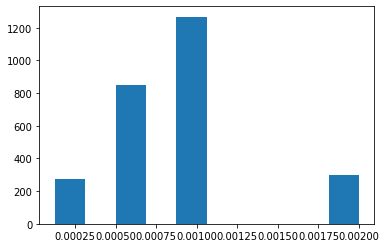

In [17]:
plt.hist(element_array_stepsize)

In [55]:
np.histogram(element_array_stepsize)

(array([ 277,    0,  847,    0, 1268,    0,    0,    0,    0,  296]),
 array([0.000125 , 0.0003125, 0.0005   , 0.0006875, 0.000875 , 0.0010625,
        0.00125  , 0.0014375, 0.001625 , 0.0018125, 0.002    ]))

In [40]:
import inspect

In [41]:
# print(inspect.getsource(np.histogram))

In [62]:
# def count_array(array, bins):
#     counts, bins = np.histogram(array, bins=bins)
#     return counts

array([ 264,  847, 1268,  296,    0])

In [63]:
learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
count_lst_stepsize.append(count_array(array = element_array_stepsize,bins=learning_bins))

NameError: name 'count_lst_stepsize' is not defined

# testing neural time steps

In [6]:
lasso_fraction = 0.5
integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate,lasso_fraction)



In [16]:
# get_integrate_system_dormand_prince_asynchronous
# get_compute_next_stepsize_neural_learning_rate

In [7]:
integrate_system_dormand_prince_asynchronous

CPUDispatcher(<function get_integrate_system_dormand_prince_asynchronous.<locals>.integrate_system_dormand_prince_asynchronous at 0x1337e9f70>)

In [8]:
integrate_system_dormand_prince_asynchronous?

In [9]:
tf = 0.001
integrate_system_dormand_prince_asynchronous(
    tf,
    element_array_time,
    element_array_stepsize,
    node_array_time,
    element_array_index,
    vertices,
    velocities,
    node_array_mass,
    element_array_inverse_equilibrium_position,
    element_array_mass
)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:92: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  energy_prev = comp_element_energy ( mass_of_K, v, W, Bm, Ds, mu, lam)
/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_dormand_prince_asynchronous.py:95: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  max_err, mav_err, x_out,v_out = one_step_explicit_dormand_prince_method(h,x,v,K_masses,K_tau,tau_of_K,Bm)


True

In [10]:
tf = 0.002
integrate_system_dormand_prince_asynchronous(
    tf,
    element_array_time,
    element_array_stepsize,
    node_array_time,
    element_array_index,
    vertices,
    velocities,
    node_array_mass,
    element_array_inverse_equilibrium_position,
    element_array_mass
)

True

In [11]:
tf = 0.004
integrate_system_dormand_prince_asynchronous(
    tf,
    element_array_time,
    element_array_stepsize,
    node_array_time,
    element_array_index,
    vertices,
    velocities,
    node_array_mass,
    element_array_inverse_equilibrium_position,
    element_array_mass
)

True

In [12]:
tf = 0.007
integrate_system_dormand_prince_asynchronous(
    tf,
    element_array_time,
    element_array_stepsize,
    node_array_time,
    element_array_index,
    vertices,
    velocities,
    node_array_mass,
    element_array_inverse_equilibrium_position,
    element_array_mass
)

True

# test step_forward_and_learn_simple

In [7]:
# get_integrate_system_explicit_asynchronous(mu,lam,gamma)

In [8]:
# from lib.controller.integrate_forward_explicit_asynchronous import get_integrate_system_explicit_asynchronous
# .integrate_forward_explicit_asynchronous import *
# from lib.controller.step_and_learn import *

In [4]:
integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

In [5]:
tf = 0.001
atol_x = 0.001
atol_v = 0.001

In [6]:
# from lib.controller.step_and_learn import *
step_forward_and_learn = get_step_forward_and_learn(mu,lam,gamma,num_iter = 30)

zero_mat = np.zeros((4,3))
def get_step_to_time(mu,lam,gamma,num_iter = 30):
    # step_to_time = get_local_one_step_implicit_midpoint_rule(mu,lam,gamma,num_iter = 30)
    step_to_time   = get_compute_one_step_forward_euler_method(mu,lam,gamma)
    # step_to_time = get_one_step_forward_euler_method(mu,lam,gamma)
    return step_to_time
step_to_time = get_step_to_time(mu,lam,gamma,num_iter = 30)


In [7]:
element_array_stepsize
K_index = 0
t_given = tf

In [9]:
from lib.controller.simple_explicit_time_adaptation import *

In [10]:
step_forward_and_learn_simple = get_step_forward_and_learn_simple(mu,lam,gamma)

In [14]:
t_given = 0.01
for K_index in range(N_elements):
    Ka = element_array_index[K_index]
    K_tau = node_array_time[Ka]
    tau_of_K = element_array_time[K_index]
    Bm  = element_array_inverse_equilibrium_position[K_index]
    K_masses = node_array_mass[Ka]
    x_current = vertices[Ka]
    v_current = velocities[Ka]
    #split the elemental configuration into three possibiities
    x_A = x_current.copy()
    x_B = x_current.copy()
    x_C = x_current.copy()
    v_A = v_current.copy()
    v_B = v_current.copy()
    v_C = v_current.copy()
    tau_of_K_A = tau_of_K.copy()
    tau_of_K_B = tau_of_K.copy()
    tau_of_K_C = tau_of_K.copy()
    K_tau_A = K_tau.copy()# K_tau_A[0] += 0.01
    K_tau_B = K_tau.copy()
    K_tau_C = K_tau.copy()
    #define time steps options
    DT_given   = t_given - tau_of_K
    DT_lesser  = DT_given/2
    DT_greater = DT_given*2
    t_lesser   = DT_lesser  + tau_of_K
    t_greater  = DT_greater + tau_of_K
    next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_lesser, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v, btol_x, btol_v, learning_rate)


In [15]:
next_stepsize

0.0005

In [16]:
t_given = tf + next_stepsize
for K_inddex in range(N_elements):
    Ka = element_array_index[K_index]
    K_tau = node_array_time[Ka]
    tau_of_K = element_array_time[K_index]
    Bm  = element_array_inverse_equilibrium_position[K_index]
    K_masses = node_array_mass[Ka]
    x_current = vertices[Ka]
    v_current = velocities[Ka]
    #split the elemental configuration into three possibiities
    x_A = x_current.copy()
    x_B = x_current.copy()
    x_C = x_current.copy()
    v_A = v_current.copy()
    v_B = v_current.copy()
    v_C = v_current.copy()
    tau_of_K_A = tau_of_K.copy()
    tau_of_K_B = tau_of_K.copy()
    tau_of_K_C = tau_of_K.copy()
    K_tau_A = K_tau.copy()# K_tau_A[0] += 0.01
    K_tau_B = K_tau.copy()
    K_tau_C = K_tau.copy()
    #define time steps options
    DT_given   = t_given - tau_of_K
    DT_lesser  = DT_given/2
    DT_greater = DT_given*2
    t_lesser   = DT_lesser  + tau_of_K
    t_greater  = DT_greater + tau_of_K
    next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_lesser, node_array_time, element_array_time, vertices, velocities, element_array_index, 
                           element_array_inverse_equilibrium_position, node_array_mass, atol_x, atol_v, btol_x, btol_v)


# test integrate_system_explicit_asynchronous

In [40]:
integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

tf = 0.001
integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, 
                                          node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

In [42]:
tf = 0.002
integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, 
                                          node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

True

In [44]:
set(element_array_stepsize)

{0.0016000000000000003}

In [45]:
elem#ent_array_time

array([0.0015, 0.0015, 0.0015, ..., 0.0015, 0.0015, 0.0015])

In [11]:
element_array_stepsize

array([0.    , 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001])